In [33]:
import numpy as np
import pandas as pd
import feather
import gc
import pickle as pkl
from pathlib import Path
from typing import *
from sklearn.preprocessing import RobustScaler
from ta import add_all_ta_features


def _load_bybit_data(rootdir: Path, interval: str):
    datadir = rootdir / "data" / "bybit" / interval

    dfs = list()
    for i in range(1, 10):
        dfs.append(feather.read_dataframe(datadir / f"data_{i}.feather"))
    df = pd.concat(dfs).reset_index(drop=True)
    del dfs
    gc.collect()

    df = df[["open_time", "close", "high", "low", "volume"]].astype(float).astype(int)

    df.columns = ["timestamp", "price", "max_price", "min_price", "volume"]
    df[["buy_price", "sell_price"]] = df[["max_price", "min_price"]]

    return df


def add_features(_df):
    df = _df.copy()
    df["spread_upper"] = df["max_price"] / df["price"] - 1
    df["spread_lower"] = df["min_price"] / df["price"] - 1

    df = add_all_ta_features(
        df,
        open="price_1",
        high="max_price",
        low="min_price",
        close="price",
        volume="volume",
        fillna=True,
    )
    df = df.dropna().reset_index(drop=True)
    return df


def find_cross_zero(x: np.ndarray) -> np.ndarray:
    x_len = x.shape[0] - 1
    y = np.zeros(x.shape[0]).astype(bool)
    for i in range(x.shape[0] - 1):
        if (x[x_len - i] > 0) and x[x_len - i - 1] <= 0:
            y[x_len - i] = True
        elif (x[x_len - i] < 0) and x[x_len - i - 1] >= 0:
            y[x_len - i] = True
        else:
            y[x_len - i] = False
    return y


def equal_divide_indice(length, num_divide):
    x = np.linspace(0, length - 1, length)
    indice = np.ones_like(x) * -1
    for i, thresh in enumerate(np.linspace(0, length, num_divide + 1)[:-1].astype(int)):
        indice[thresh:] = i
    return indice


def divide_with_pcs(df, num_divide, division):
    df["_eq_fold"] = equal_divide_indice(length=df.shape[0], num_divide=num_divide)
    df["fold"] = np.nan
    for i, (start, end) in enumerate(
        df.groupby("_eq_fold")[division].agg(["min", "max"]).values
    ):
        indice = (start < df[division]) & (df[division] <= end)
        df.loc[indice, "fold"] = i
    df["fold"] = df["fold"].fillna(method="ffill").fillna(method="bfill")
    return df


def add_lag_features(
    df: pd.DataFrame, features: List[str], lags: List[int]
) -> Tuple[pd.DataFrame, List[str]]:
    features_with_lags = [] + features
    for lag in lags:
        lag_features = [f"{f}_lag{lag}" for f in features]
        df[lag_features] = df[features].shift(lag)
        features_with_lags += lag_features
    df = df.dropna().reset_index(drop=True)
    return df, features_with_lags


def load_bybit_data(num_divide: int, interval: str, use_cache: bool = True) -> Tuple[pd.DataFrame, List[str]]:
    if interval not in ("1min", "5min"):
        raise Exception()

    # rootdir = Path(__file__).resolve().parent.parent.parent
    rootdir = Path().resolve().parent
    dfcachedir = rootdir / "data" / "cache" / "df"
    dfcachedir.mkdir(parents=True, exist_ok=True)

    dfpath = dfcachedir / f"ppo_df_{interval}.feather"
    featurespath = dfcachedir / f"ppo_features_{interval}.pkl"
    if dfpath.is_file() and featurespath.is_file() and use_cache:
        train = feather.read_dataframe(dfpath)
        features = pkl.load(open(featurespath, "rb"))
    else:
        df = _load_bybit_data(rootdir=rootdir, interval=interval)
        df["price_1"] = df["price"].shift(1)
        df = df.dropna().reset_index(drop=True)

        dfa = add_features(_df=df)
        features = [
            col for col in set(dfa.columns) - set(df.columns) if not col.startswith("_")
        ]

        dfa[features] = RobustScaler(quantile_range=(5, 95)).fit_transform(
            dfa[features]
        )
        dfa[features] = np.clip(dfa[features], -1, 1)

        dfa["fold"] = equal_divide_indice(length=dfa.shape[0], num_divide=num_divide)
        dfa = dfa[dfa.columns[~dfa.columns.str.startswith("_")]]

        feather.write_dataframe(dfa, dfpath)
        pkl.dump(features, open(featurespath, "wb"))

    return dfa, features

In [34]:
train, features = load_bybit_data(5, "5min", False)
train.head()

/root/.cache/pypoetry/virtualenvs/root-qv7zuvpL-py3.9/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/root/.cache/pypoetry/virtualenvs/root-qv7zuvpL-py3.9/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,timestamp,price,max_price,min_price,volume,buy_price,sell_price,price_1,spread_upper,spread_lower,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,fold
0,1609427100,28569,28569,28490,31851101,28569,28490,28490.0,-0.181339,-0.374220,...,-0.004022,0.002958,0.090037,0.087540,0.053589,-0.348553,-1.000000,0.000000,-0.348442,0.0
1,1609427400,28622,28623,28539,44585367,28623,28539,28569.0,-0.174267,-0.401272,...,-0.000488,0.049197,0.141067,0.100250,0.131471,-0.348547,0.246735,0.246517,-0.347111,0.0
2,1609427700,28559,28626,28532,21676325,28626,28532,28622.0,0.293497,-0.008553,...,0.000867,0.020687,0.088627,0.097357,0.035861,-0.348548,-0.292745,-0.293081,-0.348693,0.0
3,1609428000,28598,28620,28559,15252282,28620,28559,28559.0,-0.025635,-0.092608,...,0.003375,0.035764,0.017306,0.077279,-0.069446,-0.348545,0.181623,0.181507,-0.347713,0.0
4,1609428300,28568,28612,28567,7573875,28612,28567,28598.0,0.130396,0.174380,...,0.004456,0.017104,-0.080027,0.036975,-0.193389,-0.348545,-0.139519,-0.139599,-0.348467,0.0


In [35]:
from matplotlib import pyplot as plt
import seaborn as sns
import math
sns.set()

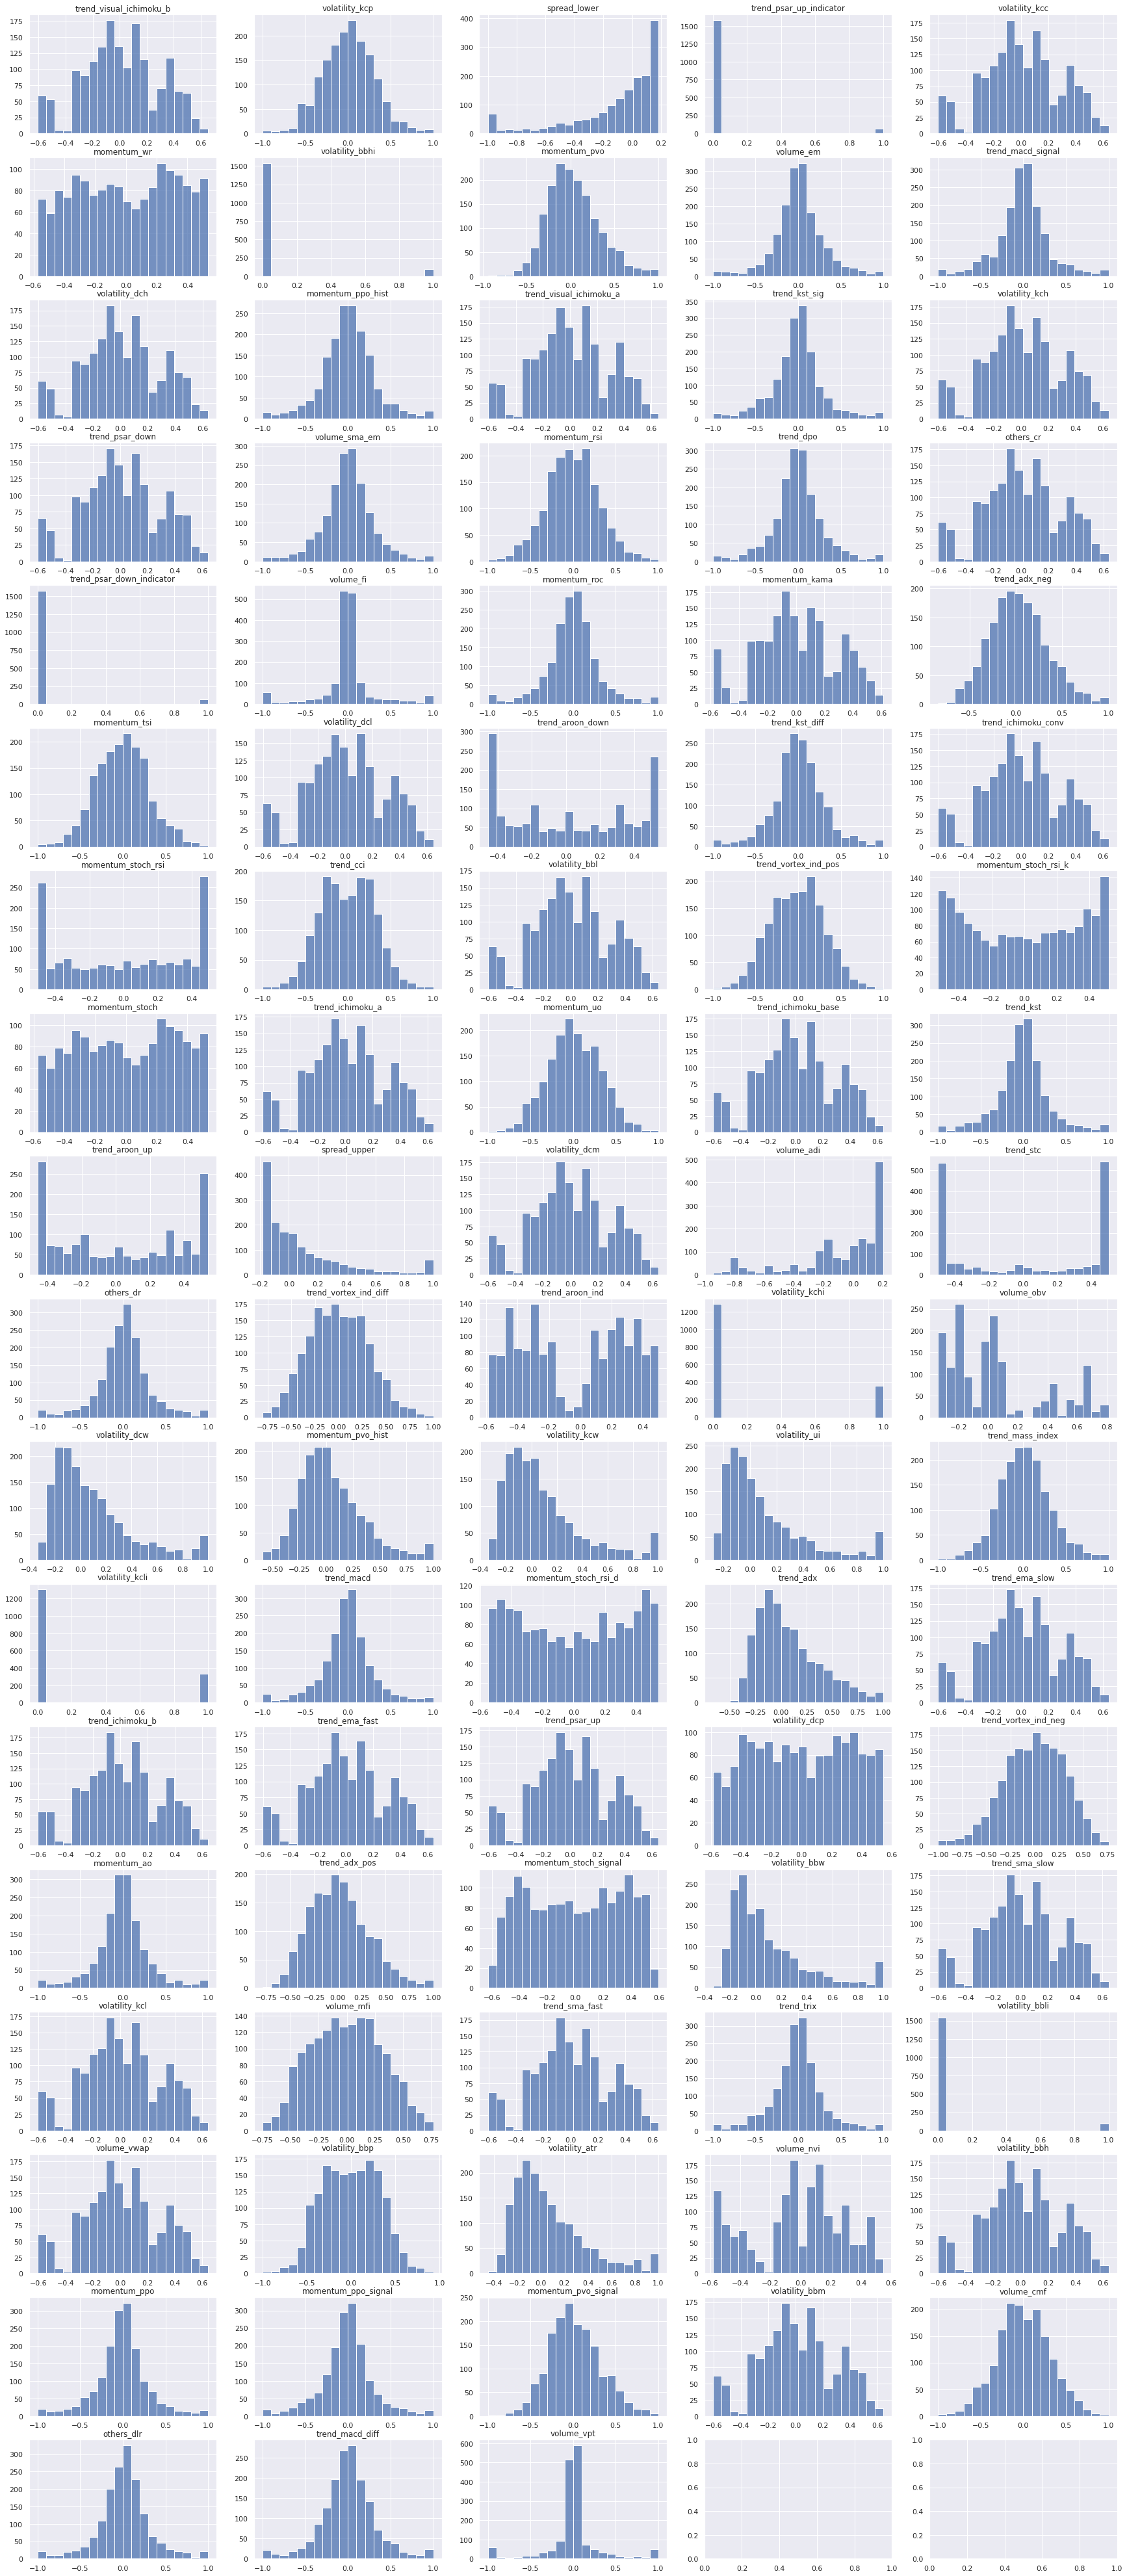

In [36]:
_train = train.iloc[::100]

ncol = 5
nrow = math.ceil(len(features) / ncol)

fig, axes = plt.subplots(nrow, ncol, figsize=(6 * ncol, 4 * nrow))
axes = axes.flatten()

for f, ax in zip(features, axes):
    sns.histplot(_train[f].values, ax=ax, bins=20)
    ax.set_ylabel("")
    ax.set_title(f)
plt.show()

In [84]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

df = train.copy()
df["fold"] = df["fold"].astype(int)
df["row"] = np.arange(df.shape[0])
rnd_indice = np.random.rand(df.shape[0]) < 0.5

df_train, df_valid = df.loc[rnd_indice, :], df.loc[~rnd_indice, :]

params = {
    "objective": "multiclass",
    "num_class": 5,
    "verbosity": -1
}

In [114]:
def train_lgb(cols: List[str]):
    train_ds = lgb.Dataset(df_train[cols], label=df_train["fold"])
    valid_ds = lgb.Dataset(df_valid[cols], label=df_valid["fold"])
    
    model = lgb.train(
        params, 
        train_ds, 
        valid_sets=[valid_ds, train_ds], 
        feval=feval_acc,
        callbacks=[
            lgb.log_evaluation(100)
        ]
    )
    train_score = accuracy_score(df_train["fold"].values, model.predict(df_train[cols].values).argmax(axis=1))
    valid_score = accuracy_score(df_valid["fold"].values, model.predict(df_valid[cols].values).argmax(axis=1))
    return model, train_score, valid_score
    
    
def feval_acc(preds, data):
    y_true = data.get_label()
    y_pred = preds.reshape(5, -1).T.argmax(axis=1)
    acc = accuracy_score(y_true, y_pred)
    return "accuracy", acc, True

In [117]:
non_stationary_check = []

for f in features:
    print(f)
    _, train_score, valid_score = train_lgb([f])
    
    non_stationary_check.append({
        "feature": f,
        "train": train_score,
        "valid": valid_score,
    })
    print()
    
non_stationary_check = pd.DataFrame(non_stationary_check)

trend_visual_ichimoku_b
[100]	training's multi_logloss: 0.924742	training's accuracy: 0.582633	valid_0's multi_logloss: 0.933989	valid_0's accuracy: 0.57926

volatility_kcp
[100]	training's multi_logloss: 1.59888	training's accuracy: 0.235419	valid_0's multi_logloss: 1.60963	valid_0's accuracy: 0.212064

spread_lower
[100]	training's multi_logloss: 1.56069	training's accuracy: 0.27424	valid_0's multi_logloss: 1.57061	valid_0's accuracy: 0.260973

trend_psar_up_indicator
[100]	training's multi_logloss: 1.6094	training's accuracy: 0.201692	valid_0's multi_logloss: 1.60946	valid_0's accuracy: 0.199379

volatility_kcc
[100]	training's multi_logloss: 0.940331	training's accuracy: 0.576311	valid_0's multi_logloss: 0.952084	valid_0's accuracy: 0.574195

momentum_wr
[100]	training's multi_logloss: 1.59827	training's accuracy: 0.235273	valid_0's multi_logloss: 1.60978	valid_0's accuracy: 0.208737

volatility_bbhi
[100]	training's multi_logloss: 1.60934	training's accuracy: 0.202398	valid_0's mu

### 方針

スコアが0.3以下の特徴量のみを採用する

<AxesSubplot:>

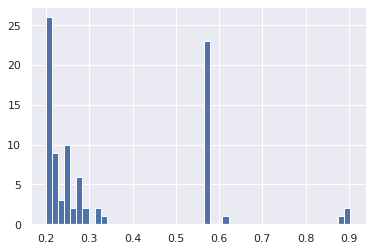

In [121]:
non_stationary_check["valid"].hist(bins=50)

In [137]:
ta_ok = non_stationary_check.loc[non_stationary_check["valid"] <= 0.3].sort_values("feature")
ta_ok

,feature,train,valid
65,momentum_ao,0.286885,0.277060
80,momentum_ppo,0.261790,0.246917
11,momentum_ppo_hist,0.255079,0.237865
81,momentum_ppo_signal,0.263128,0.247199
7,momentum_pvo,0.243298,0.218878
51,momentum_pvo_hist,0.236623,0.215734
82,momentum_pvo_signal,0.242751,0.222903
22,momentum_roc,0.254690,0.235663
17,momentum_rsi,0.231565,0.204761
35,momentum_stoch,0.235273,0.208737


In [138]:
rootdir = Path().resolve().parent
tadir = rootdir / "data/ta"

In [139]:
ta_ok.to_csv(tadir / "03.csv")

In [190]:
non_stationary_check.loc[non_stationary_check["feature"].str.startswith("volatility_bb")]

,feature,train,valid
6,volatility_bbhi,0.202398,0.200088
32,volatility_bbl,0.576591,0.574403
68,volatility_bbw,0.286739,0.274736
74,volatility_bbli,0.201571,0.200431
76,volatility_bbp,0.230702,0.200418
79,volatility_bbh,0.578840,0.575859
83,volatility_bbm,0.577940,0.575859


In [193]:
ta_ok.loc[ta_ok["feature"].str.startswith("momentum_pvo")]

,feature,train,valid
7,momentum_pvo,0.243298,0.218878
51,momentum_pvo_hist,0.236623,0.215734
82,momentum_pvo_signal,0.242751,0.222903


In [283]:
volume = {
    "ChaikinMoneyFlowIndicator": [{}],
    "EaseOfMovementIndicator": [{"window": 14}],
    "MFIIndicator": [{"window": 14}],
}
volatility = {
    "BollingerBands": [{"window": 20, "window_dev": 2}],
    "KeltnerChannel": [{"window": 10}],
    "DonchianChannel": [{"window": 20}],
    "UlcerIndex": [{"window": 14}],
}
momentum = {
    "RSIIndicator": [{"window": 14}],
    "StochRSIIndicator": [{"window": 14, "smooth1": 3, "smooth2": 3}],
    "TSIIndicator": [{"window_slow": 25, "window_fast": 13}],
    "UltimateOscillator": [{"window1": 7, "window2": 14, "window3": 28, "weight1": 4.0, "weight2": 2.0, "weight3": 1.0}],
    "StochasticOscillator": [{"window": 14, "smooth_window": 3}],
    "WilliamsRIndicator": [{"lbp": 14}],
    "AwesomeOscillatorIndicator": [{"window1": 5, "window2": 34}],
    "ROCIndicator": [{"window": 12}],
    "PercentagePriceOscillator": [{"window_slow": 26, "window_fast": 12, "window_sign": 9}],
    "PercentageVolumeOscillator": [{"window_slow": 26, "window_fast": 12, "window_sign": 9}],
}
trend = {
    "MACD": [{"window_slow": 26, "window_fast": 12, "window_sign": 9}],
    "VortexIndicator": [{"window": 14}],
    "TRIXIndicator": [{"window": 15}],
    "MassIndex": [{"window_fast": 9, "window_slow": 25}],
    "DPOIndicator": [{"window": 20}],
    "KSTIndicator": [{"roc1": 10, "roc2": 15, "roc3": 20, "roc4": 30, "window1": 10, "window2": 10, "window3": 10, "window4": 15, "nsig": 9}],
    "STCIndicator": [{"window_slow": 50, "window_fast": 23, "cycle": 10, "smooth1": 3, "smooth2": 3}],
    "ADXIndicator": [{"window": 14}],
    "CCIIndicator": [{"window": 20}],
    "AroonIndicator": [{"window": 25}],
    "PSARIndicator": [{}],
}
param = {}
param.update(volume)
param.update(volatility)
param.update(momentum)
param.update(trend)

In [284]:
method = {
    "ChaikinMoneyFlowIndicator": {"chaikin_money_flow": "cmf"},
    "EaseOfMovementIndicator": {"ease_of_movement": "em", "sma_ease_of_movement": "sma_em"},
    "MFIIndicator": {"money_flow_index": "mfi"},
    "BollingerBands": {"bollinger_wband": "bbw", "bollinger_pband": "bbp", "bollinger_hband_indicator": "bbhi", "bollinger_lband_indicator": "bbli"},
    "KeltnerChannel": {"keltner_channel_wband": "kcw", "keltner_channel_pband": "kcp", "keltner_channel_hband_indicator": "kchi", "keltner_channel_lband_indicator": "kcli"},
    "DonchianChannel": {"donchian_channel_wband": "dcw", "donchian_channel_pband": "dcp"},
    "UlcerIndex": {"ulcer_index": "ui"},
    "RSIIndicator": {"rsi": "rsi"},
    "StochRSIIndicator": {"stochrsi": "stoch_rsi", "stochrsi_k": "stoch_rsi_k", "stochrsi_d": "stoch_rsi_d"},
    "TSIIndicator": {"tsi": "tsi"},
    "UltimateOscillator": {"ultimate_oscillator": "uo"},
    "StochasticOscillator": {"stoch": "stoch", "stoch_signal": "stoch_signal"},
    "WilliamsRIndicator": {"williams_r": "wr"},
    "AwesomeOscillatorIndicator": {"awesome_oscillator": "ao"},
    "ROCIndicator": {"roc": "roc"},
    "PercentagePriceOscillator": {"ppo": "ppo", "ppo_signal": "ppo_signal", "ppo_hist": "ppo_hist"},
    "PercentageVolumeOscillator": {"pvo": "pvo", "pvo_signal": "pvo_signal", "pvo_hist": "pvo_hist"},
    "MACD": {"macd": "macd", "macd_signal": "macd_signal", "macd_diff": "macd_diff"},
    "VortexIndicator": {"vortex_indicator_pos": "vortex_ind_pos", "vortex_indicator_neg": "vortex_ind_neg", "vortex_indicator_diff": "vortex_ind_diff"},
    "TRIXIndicator": {"trix": "trix"},
    "MassIndex": {"mass_index": "mass_index"},
    "DPOIndicator": {"dpo": "dpo"},
    "KSTIndicator": {"kst": "kst", "kst_sig": "kst_sig", "kst_diff": "kst_diff"},
    "STCIndicator": {"stc": "stc"},
    "ADXIndicator": {"adx": "adx", "adx_pos": "adx_pos", "adx_neg": "adx_neg"},
    "CCIIndicator": {"cci": "cci"},
    "AroonIndicator": {"aroon_up": "aroon_up", "aroon_down": "aroon_down", "aroon_indicator": "aroon_ind"},
    "PSARIndicator": {"psar_up_indicator": "psar_up_indicator", "psar_down_indicator": "psar_down_indicator"},
}

In [285]:
ohlcv = {
    "ChaikinMoneyFlowIndicator": "hlcv",
    "EaseOfMovementIndicator": "hlv",
    "MFIIndicator": "hlcv",
    "BollingerBands": "c",
    "KeltnerChannel": "chl",
    "DonchianChannel": "hlc",
    "UlcerIndex": "c",
    "RSIIndicator": "c",
    "StochRSIIndicator": "c",
    "TSIIndicator": "c",
    "UltimateOscillator": "hlc",
    "StochasticOscillator": "hlc",
    "WilliamsRIndicator": "hlc",
    "AwesomeOscillatorIndicator": "hl",
    "ROCIndicator": "c",
    "PercentagePriceOscillator": "c",
    "PercentageVolumeOscillator": "v",
    "MACD": "c",
    "VortexIndicator": "hlc",
    "TRIXIndicator": "c",
    "MassIndex": "hl",
    "DPOIndicator": "c",
    "KSTIndicator": "c",
    "STCIndicator": "c",
    "ADXIndicator": "hlc",
    "CCIIndicator": "hlc",
    "AroonIndicator": "c",
    "PSARIndicator": "hlc",
}

In [286]:
ta_dict = {}
for k in param.keys():
    ta_dict[k] = {
        "params": param[k], "method": method[k], "ohlcv": ohlcv[k]
    }

In [287]:
nmin = 1
periods = [
    30 * 1 // nmin,
    15 * 1 // nmin,
    5 * 1 // nmin,
    1 * 1 // nmin,
]

In [288]:
for k, v in ta_dict.items():
    default = ta_dict[k]["params"][0]
    _params = []
    if len(default) > 0:
        for period in periods:
            _param = {}
            for _pname, _pvalue in default.items():
                _param[_pname] = _pvalue * period
            _params.append(_param)
    else:
        _params.append({})
    ta_dict[k]["params"] = _params

In [289]:
from ta.momentum import (
    AwesomeOscillatorIndicator,
    KAMAIndicator,
    PercentagePriceOscillator,
    PercentageVolumeOscillator,
    ROCIndicator,
    RSIIndicator,
    StochasticOscillator,
    StochRSIIndicator,
    TSIIndicator,
    UltimateOscillator,
    WilliamsRIndicator,
)
from ta.others import (
    CumulativeReturnIndicator,
    DailyLogReturnIndicator,
    DailyReturnIndicator,
)
from ta.trend import (
    MACD,
    ADXIndicator,
    AroonIndicator,
    CCIIndicator,
    DPOIndicator,
    EMAIndicator,
    IchimokuIndicator,
    KSTIndicator,
    MassIndex,
    PSARIndicator,
    SMAIndicator,
    STCIndicator,
    TRIXIndicator,
    VortexIndicator,
)
from ta.volatility import (
    AverageTrueRange,
    BollingerBands,
    DonchianChannel,
    KeltnerChannel,
    UlcerIndex,
)
from ta.volume import (
    AccDistIndexIndicator,
    ChaikinMoneyFlowIndicator,
    EaseOfMovementIndicator,
    ForceIndexIndicator,
    MFIIndicator,
    NegativeVolumeIndexIndicator,
    OnBalanceVolumeIndicator,
    VolumePriceTrendIndicator,
    VolumeWeightedAveragePrice,
)

In [290]:
df = _load_bybit_data(rootdir=rootdir, interval="1min")
df["open"] = df["price"].shift(1)
df = df.dropna().reset_index(drop=True)
df = df.rename(columns={"price": "close", "max_price": "high", "min_price": "low"})
df.head(1)

,timestamp,close,high,low,volume,buy_price,sell_price,open
0,1609426860,28396,28396,28383,1760629,28396,28383,28383.0


In [291]:
def make_args(df, ohlcv: str) -> Dict[str, pd.DataFrame]:
    args = {}
    for k in ohlcv:
        if k == "o":
            args["open"] = df["open"]
        elif k == "h":
            args["high"] = df["high"]
        elif k == "l":
            args["low"] = df["low"]
        elif k == "c":
            args["close"] = df["close"]
        elif k == "v":
            args["volume"] = df["volume"]
    return args

In [292]:
values = {}

for cls_name, cls_config in ta_dict.items():
    print(cls_name, "・・・", end="")
    
    ta_cls = globals()[cls_name]

    params, method, ohlcv = cls_config["params"], cls_config["method"], cls_config["ohlcv"]
    args = make_args(df=df, ohlcv=ohlcv)


    for i, _param in enumerate(params):
        ta_instance = ta_cls(**args, **_param)

        for method_name, prefix in method.items():
            values[f"{cls_name}_{prefix}_{i + 1}"] = getattr(ta_instance, method_name)()
    
    print(" Done.")
dfa = pd.DataFrame(values)

ChaikinMoneyFlowIndicator ・・・ Done.
EaseOfMovementIndicator ・・・ Done.
MFIIndicator ・・・ Done.
BollingerBands ・・・ Done.
KeltnerChannel ・・・ Done.
DonchianChannel ・・・ Done.
UlcerIndex ・・・ Done.
RSIIndicator ・・・ Done.
StochRSIIndicator ・・・ Done.
TSIIndicator ・・・ Done.
UltimateOscillator ・・・ Done.
StochasticOscillator ・・・ Done.
WilliamsRIndicator ・・・ Done.
AwesomeOscillatorIndicator ・・・ Done.
ROCIndicator ・・・ Done.
PercentagePriceOscillator ・・・ Done.
PercentageVolumeOscillator ・・・ Done.
MACD ・・・ Done.
VortexIndicator ・・・ Done.
TRIXIndicator ・・・ Done.
MassIndex ・・・ Done.
DPOIndicator ・・・ Done.
KSTIndicator ・・・ Done.
STCIndicator ・・・ Done.
ADXIndicator ・・・

/root/.cache/pypoetry/virtualenvs/root-qv7zuvpL-py3.9/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/root/.cache/pypoetry/virtualenvs/root-qv7zuvpL-py3.9/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


 Done.
CCIIndicator ・・・ Done.
AroonIndicator ・・・ Done.
PSARIndicator ・・・ Done.


In [295]:
_dfa = dfa.fillna(method="ffill")
_dfa.dropna(inplace=True)

In [298]:
tadir

PosixPath('/home/opt/data/ta')

In [299]:
import json

json.dump(ta_dict, open(tadir / "config.json", "w"))

### 指標メモ
#### 独自実装
- リターン
- 移動平均リターン
- 指数移動平均リターン

#### スキップが必要なもの
- PSARIndicator
    - indicator以外
- BollingerBand
    - bbl, bbh, bbm
- KeltnerChannel
    - kcc, kch, kcl
- DonchianChannel
    - dcl, dch, dcm

In [304]:
cachedir = rootdir / "data" / "cache" / "df"

_df = feather.read_dataframe(cachedir / "ppo_df_1min.feather")